# Application 2: Nowcasting hospitalizations

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from jax import config

config.update("jax_enable_x64", True)
from ssm4epi.models.hospitalization import (
    hospitalization_model,
    dates,
    unique_a,
    h_by_age,
    I_by_age,
)
from ssm4epi.models.util import from_consecutive_logits
from isssm.importance_sampling import mc_integration
from isssm.kalman import state_mode
from jax import vmap
from ssm4epi.patch import full_deps
import jax.numpy as jnp
from pyprojroot import here
import matplotlib.pyplot as plt
from isssm.estimation import initial_theta, mle_pgssm
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
import jax.random as jrn
import pandas as pd

In [ ]:
from typing import NamedTuple
from jaxtyping import Float, Array, PRNGKeyArray
from scipy.optimize import OptimizeResult
from isssm.typing import GLSSMProposal


class PredictionResult(NamedTuple):
    mean: Float[Array, "..."]
    sd: Float[Array, "..."]
    quantiles: Float[Array, "k ..."]
    quantiles_of_interest: Float[Array, "k"]


class HospitalizationNowcastingResult(NamedTuple):
    a_index: int
    h: Float[Array, "..."]
    I: Float[Array, "..."]
    dates: pd.DatetimeIndex
    y_miss: Float[Array, "np1 p"]
    y_true: Float[Array, "np1 p"]
    theta0: Float[Array, "5"]
    theta0_result: OptimizeResult
    proposal: GLSSMProposal
    key: PRNGKeyArray
    ess_pct: Float
    y_sum_predict: PredictionResult

In [ ]:
start_date = "2021-11-22"
end_date = "2022-04-29"

n_days_back = 100
n_weekday = 2

n_iter = 100
N_meis = 10000
N_ess = 10000
N_fit = 10000
N_predict = 10000

In [ ]:
class HospitalizationResult(NamedTuple):
    a_index: int
    h: Float[Array, "..."]
    I: Float[Array, "..."]
    y: Float[Array, "np1 p"]
    theta0: Float[Array, "5"]
    theta0_result: OptimizeResult
    theta_hat: Float[Array, "5"]
    theta_hat_result: OptimizeResult
    proposal: GLSSMProposal
    key: PRNGKeyArray
    ess_pct: Float

In [ ]:
import pickle
from isssm.util import degenerate_cholesky
from ssm4epi.models.hospitalization import account_for_nans, make_y_nan
from isssm.importance_sampling import prediction


def nowcast_hospitalizations(a_index, n_delay, date_to_nowcast):
    s = int(jnp.where(dates == date_to_nowcast)[0][0])
    i_start = s - n_days_back
    np1 = n_days_back

    h = h_by_age[a_index][:, :n_delay]
    I = I_by_age[a_index][i_start : i_start + np1]
    unique_a[a_index]

    key = jrn.PRNGKey(4234809124)

    y = h[i_start : i_start + np1]
    aux = (np1, n_delay, n_weekday, I)

    y_nan = make_y_nan(y)
    missing_y_indices = jnp.isnan(y_nan)

    with open(
        here()
        / "data"
        / "results"
        / "4_hospitalizations"
        / "showcase"
        / f"result_A{a_index}_D{n_delay}.pkl",
        "rb",
    ) as f:
        result = pickle.load(f)

    theta_manual = result.theta0

    missing_s_indicies = jnp.concatenate(
        (jnp.full((np1, 1), False, dtype=bool), missing_y_indices[:, :-1]), axis=-1
    )

    _, y_miss = account_for_nans(
        hospitalization_model(theta_manual, aux),
        y_nan,
        missing_y_indices,
        missing_s_indicies,
    )
    _model_miss = lambda theta, aux: account_for_nans(
        hospitalization_model(theta, aux), y_nan, missing_y_indices, missing_s_indicies
    )[0]

    theta0_missing_result = initial_theta(
        y_miss, _model_miss, theta_manual, aux, n_iter
    )
    theta0_missing = theta0_missing_result.x
    model_miss0 = _model_miss(theta0_missing, aux)
    proposal_la, info_la = LA(y_miss, model_miss0, n_iter)

    cOmega = degenerate_cholesky(proposal_la.Omega)
    Omega = cOmega @ cOmega.transpose((0, 2, 1))

    proposal_la = GLSSMProposal(
        u=proposal_la.u,
        A=proposal_la.A,
        D=proposal_la.D,
        Sigma0=proposal_la.Sigma0,
        Sigma=proposal_la.Sigma,
        v=proposal_la.v,
        B=proposal_la.B,
        Omega=Omega,
        z=proposal_la.z,
    )

    # key, subkey = jrn.split(key)
    # proposal_meis, info_meis = MEIS(
    #    y_miss,
    #    model_miss0,
    #    proposal_la.z,
    #    proposal_la.Omega,
    #    n_iter,
    #    N_meis,
    #    subkey,
    # )

    key, subkey = jrn.split(key)
    _, log_weights = pgssm_importance_sampling(
        y_miss,
        model_miss0,
        proposal_la.z,
        proposal_la.Omega,
        N_fit,
        subkey,
    )

    def f_nowcast(x, s, y):
        return jnp.sum(
            (missing_y_indices * y) + (1 - missing_y_indices) * y_miss, axis=-1
        )

    key, subkey = jrn.split(key)
    preds = prediction(
        f_nowcast,
        y_miss,
        proposal_la,
        _model_miss(theta0_missing, aux),
        N_predict,
        subkey,
        jnp.array([0.025, 0.5, 0.975]),
        hospitalization_model(theta0_missing, aux),
    )

    result = HospitalizationNowcastingResult(
        a_index=a_index,
        h=h,
        I=I,
        y_miss=y_miss,
        y_true=y,
        dates=dates[i_start : i_start + np1],
        theta0=theta0_missing,
        theta0_result=theta0_missing_result,
        proposal=proposal_la,
        key=key,
        ess_pct=ess_pct(log_weights),
        y_sum_predict=preds,
    )

    with open(
        here()
        / "data"
        / "results"
        / "4_hospitalizations"
        / "nowcast"
        / f"nowcast_A{a_index}_D{n_delay}_{date_to_nowcast}.pkl",
        "wb",
    ) as f:
        pickle.dump(result, f)

    return result

In [ ]:
from ssm4epi.models.hospitalization import delays_per_age


initial_date = "2021-11-22"
results = delays_per_age.apply(
    lambda x: nowcast_hospitalizations(x[0], x[1], initial_date), axis=1
)

[None, None, None, None, None, None, None]

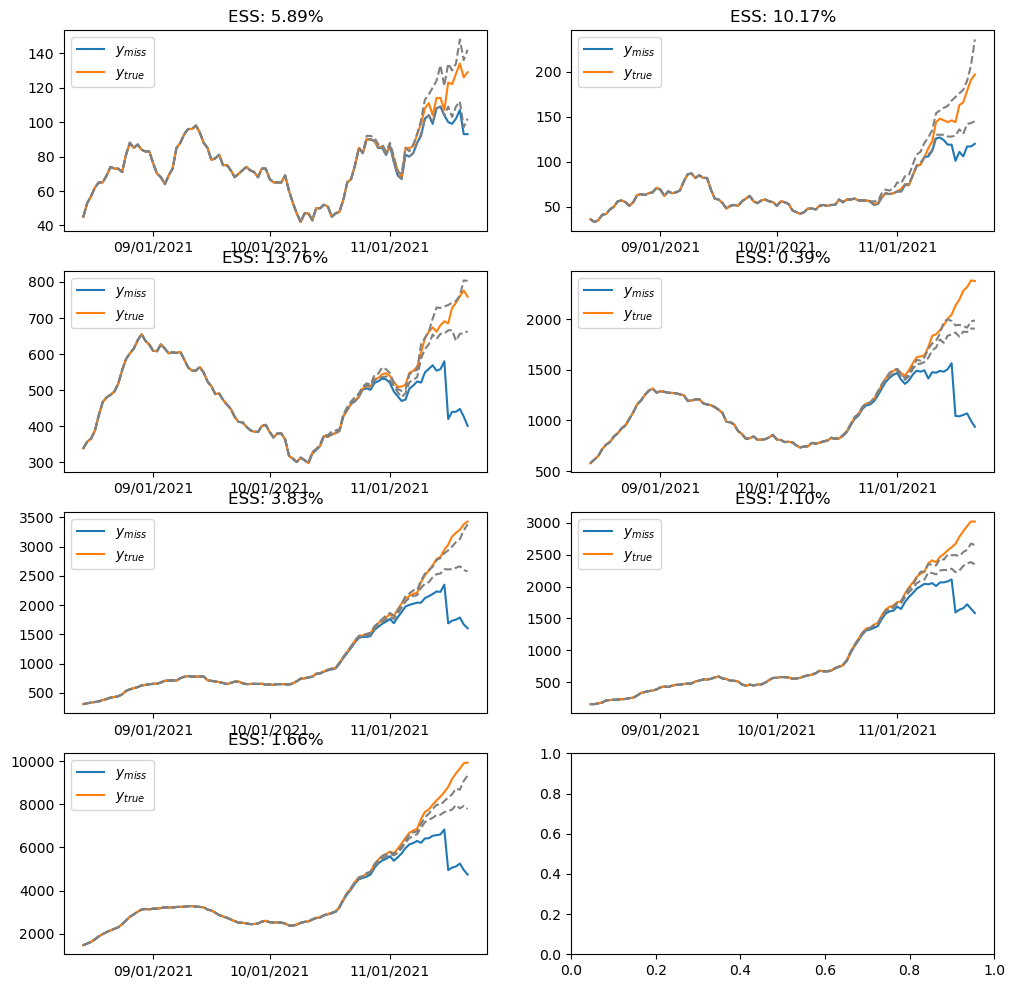

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import dates as mdates


def visualize(result: HospitalizationNowcastingResult, ax: plt.Axes = None):
    ax.set_title(f"ESS: {result.ess_pct * 100 :.2f}%")

    dates = pd.to_datetime(result.dates)
    y = result.y_true
    ax.plot(dates, result.y_miss.sum(axis=-1), label="$y_{miss}$")
    ax.plot(dates, y.sum(axis=-1), label="$y_{true}$")
    # plt.plot(result.y_sum_predict[0], color="black")
    ax.plot(dates, result.y_sum_predict[2][0], "--", color="gray")
    ax.plot(dates, result.y_sum_predict[2][-1], "--", color="gray")
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d/%Y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator())

_, axs = plt.subplots(4, 2, figsize=(12, 12))

[visualize(result, ax) for result, ax in zip(results, axs.flatten()[:-1])]